# Stack Overflow

## Introduction 

In the second part of this assignment, we will create and analyze time series of creation dates of Stack Overflow questions. This assignment is to be completed **INDIVIDUALLY** and it is due on **October 7 at 7pm**.

Let's create some time series from the data. You may choose to analyze either users or tags. To analyze users, take the top 100 users with the most question posts. For each user, your time series will be the number of questions posted by that user at some frequency. To analyze tags, take the top 100 most popular question tags. For each tag, your time series will be the number of questions with that tag at some frequency. You may choose to sample your data each week, each month, on a certain day of the week or at certain hours in a day depending on what trend you are hoping to find in the data. For example, if you choose to analyze tags and sample during different hours of the day, your hypothesis could be that languages (i.e. Javascript) that are used more in industry will have more questions posted during work hours, whereas languages (i.e. Python) that are taught in academia will have more questions posted after midnight when students are scrambling to finish their homework.

Compare the time series using one of the methods discussed in class. In a few paragraphs, write down what you were hoping to find in the data, what timeseries you created, what method you chose and why. **(30 pts)**

You may find the [pandas.DataFrame.resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) module helpful.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import xml.etree.ElementTree as et
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
import seaborn as sns
import csv
%matplotlib inline

# create iterator over elem tree 
itertree = iter(et.iterparse('stackoverflow-posts-2015.xml', ('start', 'end')))

# get root elem
event, root = next(itertree)

questionPost = {}
questionPosts = []

for event, elem in itertree:
    if event == 'start' and elem.tag == 'row' and elem.get('PostTypeId','') == '1':
        # reinit dict for new row
        questionPost = {}    
        # get question Id
        questionPost['Id'] = elem.get('Id','')
        # get CreationDate date/time
        questionPost['CreationDate'] = pd.to_datetime(elem.get('CreationDate',''))
        # get OwnerUserId
        questionPost['OwnerUserId'] = elem.get('OwnerUserId','')
        # get first in Tags
        t = elem.get('Tags','')
        questionPost['Tags'] = t[t.find("<")+1:t.find(">")]
        # add current post row to aggregate list of question posts
        questionPosts.append(questionPost) 
    # clear root to prevent excess references in memory
    root.clear() 
 
question_df = pd.DataFrame(questionPosts, columns=['Id', 'CreationDate', 'OwnerUserId', 'Tags'])
question_df.to_csv('question_dataframe.csv', index=False)
qdf = pd.read_csv('question_dataframe.csv')

# Get top 100 most frequently used tags
top100tags = pd.DataFrame(qdf.groupby('Tags').size().rename('TagFrequency'), columns=['TagFrequency']).nlargest(100, 'TagFrequency')

FileNotFoundError: [Errno 2] No such file or directory: 'stackoverflow-posts-2015.xml'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import xml.etree.ElementTree as et
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
import seaborn as sns
import csv
%matplotlib inline

qdf = pd.read_csv('question_dataframe.csv')
top100tags = pd.DataFrame(qdf.groupby('Tags').size().rename('TagFrequency'), columns=['TagFrequency']).nlargest(100, 'TagFrequency')

top100timeseries = qdf.loc[qdf['Tags'].isin(top100tags.index.values)]
top100timeseries.index = pd.to_datetime(top100timeseries['CreationDate'])
del top100timeseries['OwnerUserId']
del top100timeseries['Id']

# Create column counting each tag
tag_grouper = top100timeseries.groupby([pd.TimeGrouper('M'), 'Tags'])
tag_counter = tag_grouper['CreationDate'].count().unstack('Tags').fillna(0)
print(tag_counter)
tag_counter.index.rename('Month', inplace=True)

v = CountVectorizer()
x = v.fit_transform(tag_counter).toarray()

# Euclidean Distance
eucldists = metrics.euclidean_distances(x)

maxdist, mindist, maxrow, maxcol, minrow, mincol = 0, 9999, 0, 0, 0, 0

for r in range(len(eucldists)):
    for c in range(len(eucldists[0])):
        thisdist = eucldists[r][c]
        
        # get minimum and maximum distances
        # ignore the 0 diagonal when comparing same tag to itself
        if thisdist > maxdist and r!=c:
            maxdist = thisdist
            maxrow, maxcol = r, c 
            
        if thisdist != 0:
            if thisdist < mindist and r!=c:
                mindist = thisdist
                minrow, mincol = r, c

# print('\nmaxdist is ' + str(maxdist) + ' at (' + str(maxrow) + ',' + str(maxcol) + ') and mindist is ' + str(mindist) + ' at (' + str(minrow) + ',' + str(mincol) + ')')

fartag1, fartag2 = tag_counter.columns[maxrow], tag_counter.columns[maxcol]
closetag1, closetag2 = tag_counter.columns[minrow], tag_counter.columns[mincol] 

KeyError: 'Tags'

### Plotting Tags Farthest by Euclidean Distance

In [ ]:
# Plot tags farthest by Euclidean distance
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tag_counter.index, tag_counter[fartag1], 'r-')
ax2.plot(tag_counter.index, tag_counter[fartag2], 'b-')

ax1.set_xlabel('Month')
ax1.set_ylabel(fartag1, color='r')
ax2.set_ylabel(fartag2, color='b')

plt.title("Monthly usage of 'amazon-web-services' and 'asp.net-mvc' Tags")
plt.show()
plt.rcParams['figure.figsize'] = 9,5

### Plotting Tags Closest by Euclidean Distance

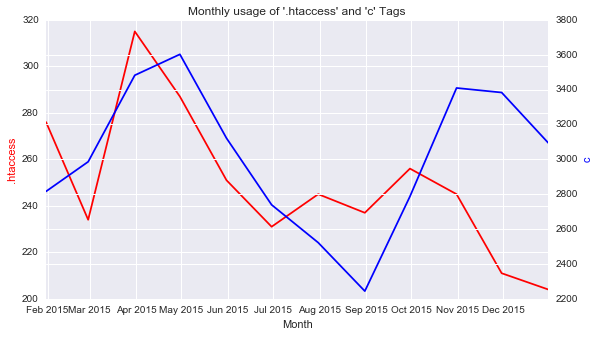

In [5]:
# Plot tags closest by Euclidean distance
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tag_counter.index, tag_counter[closetag1], 'r-')
ax2.plot(tag_counter.index, tag_counter[closetag2], 'b-')

ax1.set_xlabel('Month')
ax1.set_ylabel(closetag1, color='r')
ax2.set_ylabel(closetag2, color='b')

plt.title("Monthly usage of '.htaccess' and 'c' Tags")
plt.show()
plt.rcParams['figure.figsize'] = 9,5

Choose a different distance/similarity metric and repeat the same time series analysis. Compare the two different metrics you used. **(10 pts)**

In [6]:
# Cosine Similarity
cosinesims = metrics.pairwise.cosine_similarity(x)

maxsim, minsim, maxrow, maxcol, minrow, mincol = 0, 9999, 0, 0, 0, 0

for r in range(len(cosinesims)):
    for c in range(len(cosinesims[0])):
        thissim = cosinesims[r][c]
        
        # get minimum and maximum similarities
        # ignore the 0 diagonal when comparing same tag to itself
        if thissim > maxsim and r!=c:
            maxsim = thissim
            maxrow, maxcol = r, c 
            
        if thissim != 0:
            if thissim < minsim and r!=c:
                minsim = thissim
                minrow, mincol = r, c

# print('\nmaxsim is ' + str(maxsim) + ' at (' + str(maxrow) + ',' + str(maxcol) + ') and minsim is ' + str(minsim) + ' at (' + str(minrow) + ',' + str(mincol) + ')')

fartag1, fartag2 = tag_counter.columns[minrow], tag_counter.columns[mincol]
closetag1, closetag2 = tag_counter.columns[maxrow], tag_counter.columns[maxcol] 

### Plotting Tags Farthest by Cosine Similarity

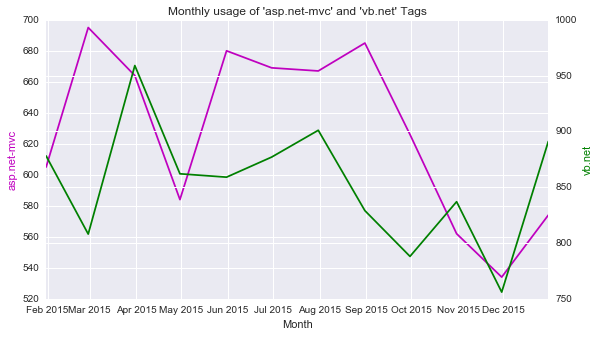

In [7]:
# Plot tags farthest by Cosine similarity
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tag_counter.index, tag_counter[fartag1], 'm-')
ax2.plot(tag_counter.index, tag_counter[fartag2], 'g-')

ax1.set_xlabel('Month')
ax1.set_ylabel(fartag1, color='m')
ax2.set_ylabel(fartag2, color='g')

plt.title("Monthly usage of 'asp.net-mvc' and 'vb.net' Tags")
plt.show()
plt.rcParams['figure.figsize'] = 9,5

### Plotting Tags Closest by Cosine Similarity

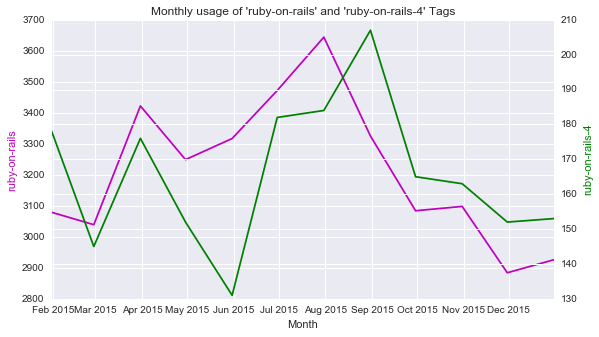

In [8]:
# Plot tags closest by Cosine similarity
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tag_counter.index, tag_counter[closetag1], 'm-')
ax2.plot(tag_counter.index, tag_counter[closetag2], 'g-')

ax1.set_xlabel('Month')
ax1.set_ylabel(closetag1, color='m')
ax2.set_ylabel(closetag2, color='g')

plt.title("Monthly usage of 'ruby-on-rails' and 'ruby-on-rails-4' Tags")
plt.show()
plt.rcParams['figure.figsize'] = 9,5

## Discussion
My hypothesis was that certain question tags would be more prevalent during certain months due to seasonality of school and interviews. My three presumptions were:
1. Tags related to academic computer science material would peak during college months
2. Software engineering related tags would be popular during job application and interview months
3. More obscure tags (advanced or less common material) would be pretty steady.

I created a time series of the frequency of each tag by month. This timeseries allowed me to see monthly seasonal variation in the usage of question tags. To do this, I first ranked the top 100 by their usage for the year. I then created a dataframe from the original question dataframe containing only the posts associated with the top 100 tags. Next, I grouped this dataframe from daily to monthly, and added a column for the count of each of the 100 top tags.

To explore my hypotheses further, I made some more plots (below). These plots do not actually support my hypotheses very well, since all of the tags I plotted are much more stable than I anticipated. 



### Plotting Some Academic Programming Languages

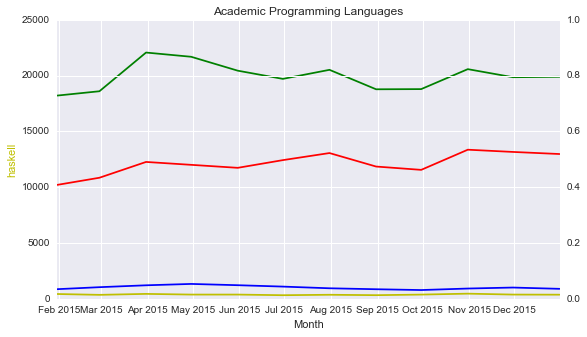

In [9]:
# Plot tags of some academic programming languages
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tag_counter.index, tag_counter['python'], 'r-')
ax1.plot(tag_counter.index, tag_counter['java'], 'g-')
ax1.plot(tag_counter.index, tag_counter['matlab'], 'b-')
ax1.plot(tag_counter.index, tag_counter['haskell'], 'y-')

ax1.set_xlabel('Month')
ax1.set_ylabel('python', color='r')
ax1.set_ylabel('java', color='g')
ax1.set_ylabel('matlab', color='b')
ax1.set_ylabel('haskell', color='y')

plt.title("Academic Programming Languages")
plt.show()
plt.rcParams['figure.figsize'] = 9,5

### Plotting Some Industry Programming Languages

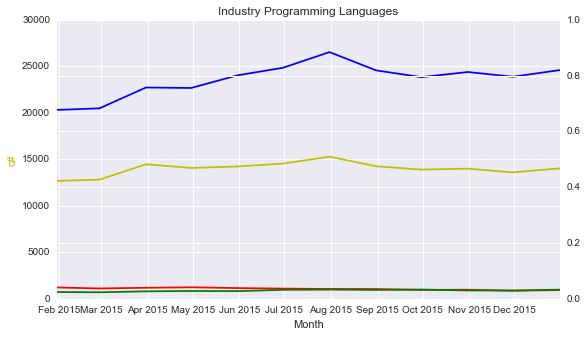

In [10]:
# Plot tags of some industry programming languages
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(tag_counter.index, tag_counter['ruby'], 'r-')
ax1.plot(tag_counter.index, tag_counter['scala'], 'g-')
ax1.plot(tag_counter.index, tag_counter['javascript'], 'b-')
ax1.plot(tag_counter.index, tag_counter['c#'], 'y-')

ax1.set_xlabel('Month')
ax1.set_ylabel('python', color='r')
ax1.set_ylabel('java', color='g')
ax1.set_ylabel('matlab', color='b')
ax1.set_ylabel('c#', color='y')

plt.title("Industry Programming Languages")
plt.show()
plt.rcParams['figure.figsize'] = 9,5